# An analysis of Medicare Claims Data

Medicare is single-payer health insurance program provided by the government mainly for Americans aged 65 and older. It is an important social insurance program with more than 50 million people. 

In this notebook, we will look at the publicly available claims data from the Center of Medicare services. The data can be downloaded from their [website](https://www.cms.gov/Research-Statistics-Data-and-Systems/Downloadable-Public-Use-Files/SynPUFs/DE_Syn_PUF.html) where claims between 2008 and 2010 are split into 20 samples. Since the whole data is quite large, we will only focus on one of the samples (Sample 1).

The aim is to understand what the distribution of costs and medical conditions across different states and demographical groups. A better understanding could improve allocation of resources and provide better healthcare for beneficiaries of the Medicare program. 

Below is a list of steps we perform to analyze the data.

* Data loading and cleaning
* Visualization
    1. Distribution of beneficiaries  and cost across states
    2. Total payment distribution
    3. Distribution of medical conditions
    4. Distribution of medical conditions by state
    5. Medical conditions with highest cost
    6. Distribution of medical conditions between genders
    7. Distribution of medical conditions among races
    8. Distribution of medical conditions among races: Comparison of CA and IL
* Conclusions

### Data loading and cleaning

In [1]:
# imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('whitegrid')

Let's load the data first and look at all the columns

In [2]:
# Load Beneficiary data
beneficiaries = pd.read_csv("./data/DE1_0_2008_Beneficiary_Summary_File_Sample_1.zip")

In [3]:
# Let's peek into the data
beneficiaries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116352 entries, 0 to 116351
Data columns (total 32 columns):
DESYNPUF_ID                 116352 non-null object
BENE_BIRTH_DT               116352 non-null int64
BENE_DEATH_DT               1814 non-null float64
BENE_SEX_IDENT_CD           116352 non-null int64
BENE_RACE_CD                116352 non-null int64
BENE_ESRD_IND               116352 non-null object
SP_STATE_CODE               116352 non-null int64
BENE_COUNTY_CD              116352 non-null int64
BENE_HI_CVRAGE_TOT_MONS     116352 non-null int64
BENE_SMI_CVRAGE_TOT_MONS    116352 non-null int64
BENE_HMO_CVRAGE_TOT_MONS    116352 non-null int64
PLAN_CVRG_MOS_NUM           116352 non-null int64
SP_ALZHDMTA                 116352 non-null int64
SP_CHF                      116352 non-null int64
SP_CHRNKIDN                 116352 non-null int64
SP_CNCR                     116352 non-null int64
SP_COPD                     116352 non-null int64
SP_DEPRESSN                 116352 no

The decription of each feature is explained in the [codebook](https://www.cms.gov/Research-Statistics-Data-and-Systems/Downloadable-Public-Use-Files/SynPUFs/Downloads/SynPUF_Codebook.pdf), which can be dowloaded from the [CMS website](https://www.cms.gov/Research-Statistics-Data-and-Systems/Downloadable-Public-Use-Files/SynPUFs/DE_Syn_PUF.html). Some of the names are not very descriptive, so for clarity, let's just rename some of the features

In [4]:
rename_dict = {"BENE_BIRTH_DT":"birthday", "BENE_DEATH_DT":"deathday", "BENE_SEX_IDENT_CD":"sex",
               "BENE_RACE_CD":"race", "BENE_ESRD_IND":"renal_disease", "SP_STATE_CODE":"state",
               "BENE_COUNTY_CD":"county", "BENE_HI_CVRAGE_TOT_MONS":"partA", 
               "BENE_SMI_CVRAGE_TOT_MONS":"partB", "BENE_HMO_CVRAGE_TOT_MONS":"hmo",
               "PLAN_CVRG_MOS_NUM":"partD", "SP_ALZHDMTA":"alzheimer", "SP_CHF":"hearth_failure",
               "SP_CHRNKIDN":"kidney_disease", "SP_CNCR":"cancer", "SP_COPD":"pulmanory_disease",
               "SP_DEPRESSN":"depression","SP_DIABETES":"diabetes","SP_ISCHMCHT":"ismechic_hearth",
               "SP_OSTEOPRS":"osteoporosis", "SP_RA_OA":"rheumatoid","SP_STRKETIA":"stroke"}

# List of conditions
diseases = ['renal_disease', 'alzheimer', 'hearth_failure', 'kidney_disease', 'cancer', 'pulmanory_disease',
            'depression', 'diabetes', 'ismechic_hearth', 'osteoporosis', 'rheumatoid','stroke']

beneficiaries = beneficiaries.rename(columns=rename_dict)

# One-hot encoding
beneficiaries['renal_disease'] = beneficiaries['renal_disease'].map(lambda x: 1 if x=="Y" else 0)

for disease in diseases[1:]:
    beneficiaries[disease] = beneficiaries[disease].map(lambda x: 1 if x==1 else 0)

Now let's process the dates and convert them into the datetime format

In [5]:
## Dates

# Birth dates
beneficiaries['birthday'] = pd.to_datetime(beneficiaries['birthday'].astype(str))

# Death dates: first get dead beneficiaries and then set their death time
dead_bene = beneficiaries[~pd.isnull(beneficiaries['deathday'])]['deathday'].astype(int).astype(str)
beneficiaries.loc[dead_bene.index,'deathday'] = pd.to_datetime(dead_bene)


Now, we collect data on three types of payments listed in the data: 1) inpatient, 2) outpatient, 3) carrier. Refer to the codebook for more information

In [6]:
## Payments

# Inpatient
beneficiaries['tot_inpatient'] = beneficiaries['MEDREIMB_IP'] + beneficiaries['BENRES_IP'] + beneficiaries['PPPYMT_IP']

# Outpatient
beneficiaries['tot_outpatient'] = beneficiaries['MEDREIMB_OP'] + beneficiaries['BENRES_OP'] + beneficiaries['PPPYMT_OP']

# Carrier
beneficiaries['tot_carrier'] = beneficiaries['MEDREIMB_CAR'] + beneficiaries['BENRES_CAR'] + beneficiaries['PPPYMT_CAR']

Now, we process demographic features (i.e. sex and race)

In [7]:
## Demographic features

# Convert to one-hot: M=1/F=0
beneficiaries['sex'] = beneficiaries['sex'].map(lambda x: 1 if x==1 else 0)

In [8]:
# Convert race encoding into clear text
def race_code(x):
    if (x == 1):
        return "white"
    elif (x==2):
        return "black"
    elif (x == 5):
        return "hispanic"
    elif (x == 3):
        return "other"

beneficiaries['race'] = beneficiaries['race'].map(lambda x: race_code(x))

## Visualization

### Distribution of beneficiaries  and cost across states

Let's look at the top ten states with the largest number of beneficiaries

In [9]:
ser = beneficiaries.groupby('state').size().sort_values(ascending = False)[:10]
ser

state
5     10224
10     7745
45     6703
33     6510
39     5199
36     4329
14     4277
23     4012
34     3935
31     3176
dtype: int64

Using the codebook, we convert the numeric codes into state abbreviations

In [10]:
# Convert into state codes
top_states = ser.index
index_state = np.array(["CA", "FL", "TX", "NY", "PA", "OH", "IL", "MI", "NC", "NJ" ])
state_dictionary = dict(zip(ser.index, index_state))

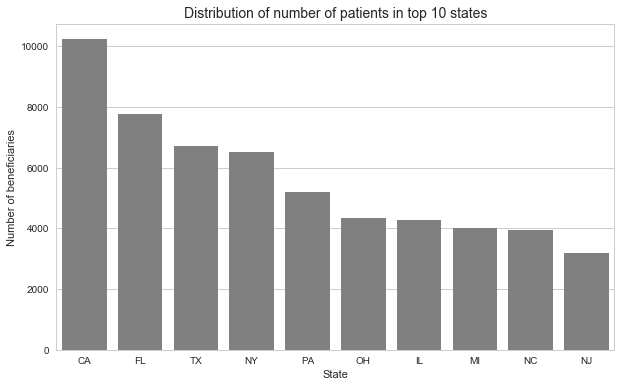

In [11]:
df = pd.DataFrame(data = {"state":index_state, "count":ser.values})

fig, ax = plt.subplots(figsize=(10,6))
ax = sns.barplot(x = 'state', y = 'count', data = df, color = 'gray')
ax.set(xlabel = 'State', ylabel = 'Number of beneficiaries')
plt.title("Distribution of number of patients in top 10 states",fontsize=14)
plt.show()

California has the largest number of beneficieres followed by Florida. This makes sense since these states have large retiree populations

### Total payment distribution

Let's look at how Medicare cost is distributed across different forms of payments

In [12]:
payments_df = beneficiaries[['tot_inpatient','tot_outpatient','tot_carrier']]
payments_df = pd.melt(payments_df)
payments_df = payments_df[payments_df['value'] > 0]

Let's divide into 5 quantiles of payments

In [13]:
payments_df['quantiles'] = pd.qcut(payments_df['value'], q = np.linspace(0,1,6),
        labels = ["0-20","20-40","40-60","60-80","80-100"])

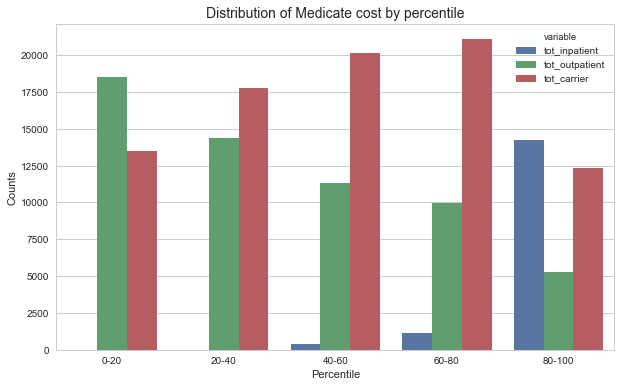

In [14]:
# Plot
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.countplot(x = 'quantiles', data = payments_df, hue = 'variable')
ax.set(xlabel = 'Percentile', ylabel = 'Counts')
plt.title("Distribution of Medicate cost by percentile",fontsize=14)
plt.show()

As can be seen, inpatient expenses have the largest share in the top percentile, and non-existent in the lowest percentile. Outpatient expenses dominate the lower percentile of payments. 

### Distribution of medical conditions

Now, let's explore how different medical conditions are distributed

In [15]:
df = pd.melt(beneficiaries[diseases], value_name='has_disease', var_name='disease')
ser = df.groupby('disease')['has_disease'].sum()
df2 = pd.DataFrame(data = {'disease':ser.index, 'count':ser.values})

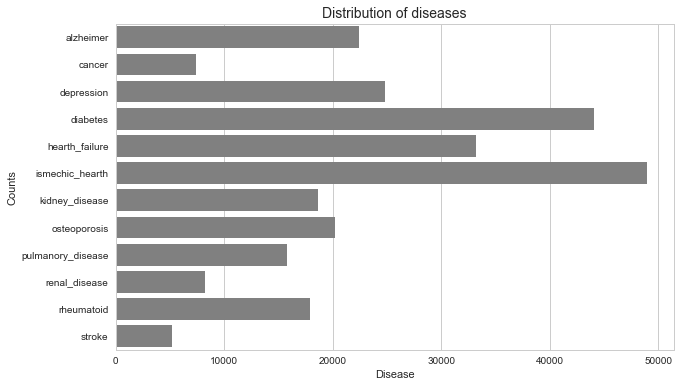

In [16]:
# Plot
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.barplot(y = 'disease', x = 'count', data = df2, color = 'gray')
ax.set(xlabel = 'Disease', ylabel = 'Counts')
plt.title("Distribution of diseases",fontsize=14)
plt.show()

As can be seen, hearth conditions (ismechic hearth disease and hearth failure) and diabetes are the most common conditions, while cancer and stroke are the rarest.

### Distribution of medical conditions by state

Now let's explore how these medical conditions are distributed across the top 10 states

In [17]:
df = pd.melt(beneficiaries[diseases + ['state']], 
             value_vars=diseases, var_name='disease', value_name='has_disease',
             id_vars = 'state')

# Filter by top states
df = df[df['state'].isin(top_states)]

In [18]:
state_size = df.groupby('state').size().reset_index()
state_size.columns = ['state','count']

Compute prevalence of conditions (by taking into account number of beneficiaries by state)

In [19]:
df2 = df.groupby(['disease','state'])['has_disease'].sum().reset_index()
df2 = pd.merge(df2, state_size, how = 'left', on='state')
df2['prevalence'] = df2['has_disease'] / df2['count']*100

In [20]:
# Replace numeric state codes with abbriviations
for k,v in state_dictionary.items():
    df.loc[df['state'] == k, 'state'] = v

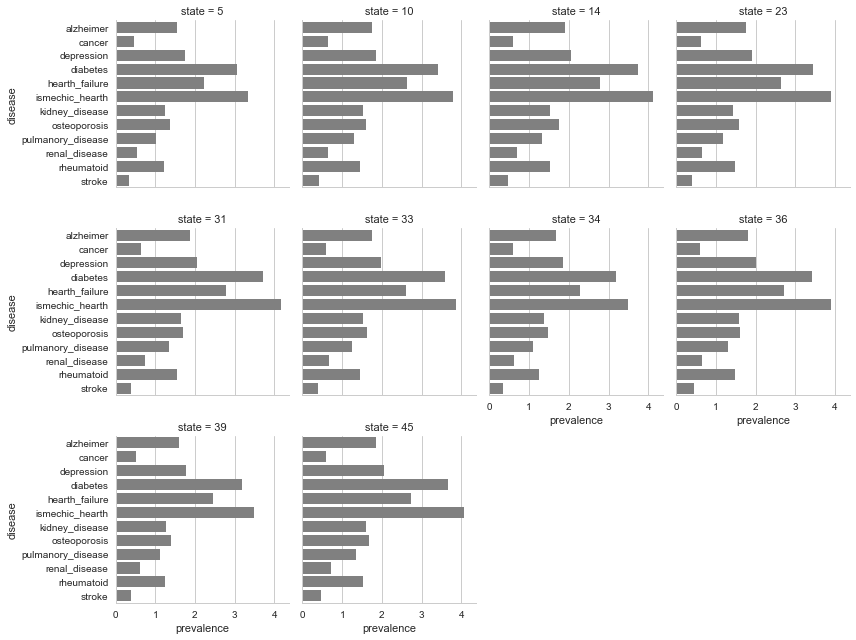

In [21]:
g = sns.FacetGrid(df2, col = 'state', col_wrap=4)
g.map(sns.barplot, "prevalence", "disease", color='gray')


Overall, the distribution of medical conditions are similar across different states.

### Medical conditions with highest cost

Now that we have explored distribution of medical conditions, let's explore the costs associated with each condition

In [22]:
df = beneficiaries[diseases + ['tot_inpatient', 'tot_outpatient', 'tot_carrier']]
df2 = pd.melt(df, value_vars=diseases, var_name = 'disease', value_name='has_disease',
       id_vars = ['tot_inpatient', 'tot_outpatient', 'tot_carrier'])

Compute total amount of each payment type by disease type

In [23]:
part1 = df2.groupby('disease')['tot_inpatient','has_disease'].apply(lambda x: x['tot_inpatient'].sum() /x['has_disease'].sum())
part2 = df2.groupby('disease')['tot_outpatient','has_disease'].apply(lambda x: x['tot_outpatient'].sum() /x['has_disease'].sum())
part3 = df2.groupby('disease')['tot_carrier','has_disease'].apply(lambda x: x['tot_carrier'].sum() /x['has_disease'].sum())

In [24]:
# Combine
df3 = pd.concat([part1,part2,part3],axis=1, keys=['inpatient','outpatient','carrier']).reset_index()
df4 = pd.melt(df3, id_vars = 'disease', var_name='payment_type', value_name='cost')

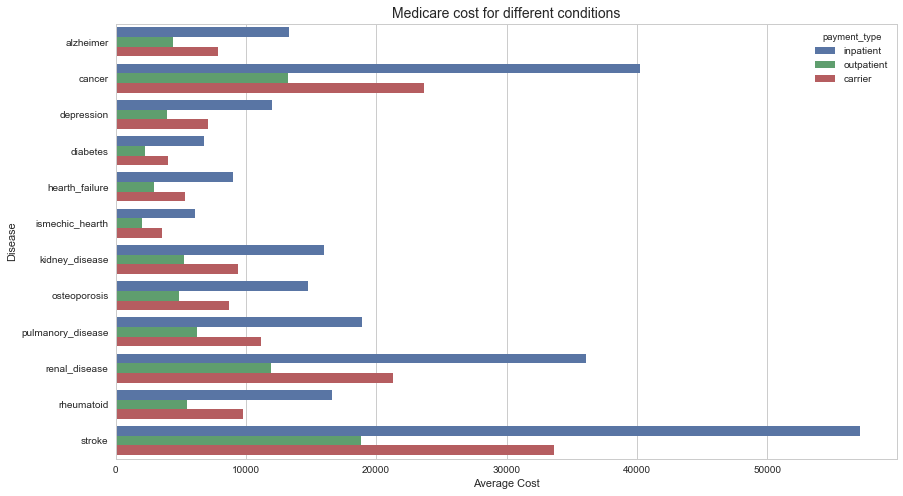

In [25]:
# Plot
fig, ax = plt.subplots(figsize=(14,8))
ax = sns.barplot(y = 'disease', x = 'cost', data =df4, hue = 'payment_type')
ax.set(ylabel = 'Disease', xlabel = 'Average Cost')
plt.title("Medicare cost for different conditions",fontsize=14)
plt.show()

Notice that while stroke is one of the two least common conditions, it is definitely the most expensive (on average) one to treat.

### Distribution of medical conditions between genders

Now that we have an idea of how different medical conditions and their costs are distributed, let's explore how demographics play a role. We first look at gender:

In [26]:
df = beneficiaries[diseases + ['sex']]
df2 = pd.melt(df, value_vars=diseases, value_name = 'has_disease', var_name='disease', id_vars = 'sex')
df3 = df2.groupby(['sex','disease'])['has_disease'].sum().reset_index()

sex_counts = beneficiaries.groupby('sex').size().reset_index()
sex_counts.columns = ['sex','sex_counts']
df3 = pd.merge(df3,sex_counts, how='left', on='sex')
df3['prevalence'] = df3['has_disease'] / df3['sex_counts'] *100

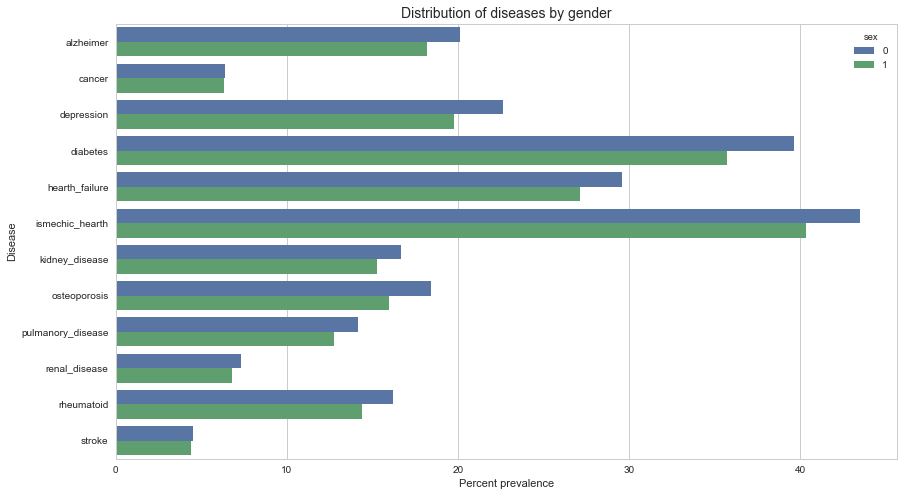

In [27]:
# Plot
fig, ax = plt.subplots(figsize=(14,8))
ax = sns.barplot(y = 'disease', x = 'prevalence', data = df3, hue = 'sex')
ax.set(ylabel = 'Disease', xlabel = 'Percent prevalence')
plt.title("Distribution of diseases by gender",fontsize=14)
plt.show()

As can be seen, the medical condition prevalences are similar in both men (coded 1) and women (coded 0), women tend to have a higher percentage in all conditions for this sample.

### Distribution of medical conditions among races

Now, let's look at the distribution of conditions among different racial backgrounds

In [28]:
df = beneficiaries[diseases + ['race']]
df2 = pd.melt(df, value_vars=diseases, value_name = 'has_disease', var_name='disease', id_vars = 'race')
df3 = df2.groupby(['race','disease'])['has_disease'].sum().reset_index()

race_counts = df.groupby('race').size().reset_index()
race_counts.columns = ['race','race_counts']
df3 = pd.merge(df3,race_counts, how='left', on='race')
df3['prevalence'] = df3['has_disease'] / df3['race_counts'] *100

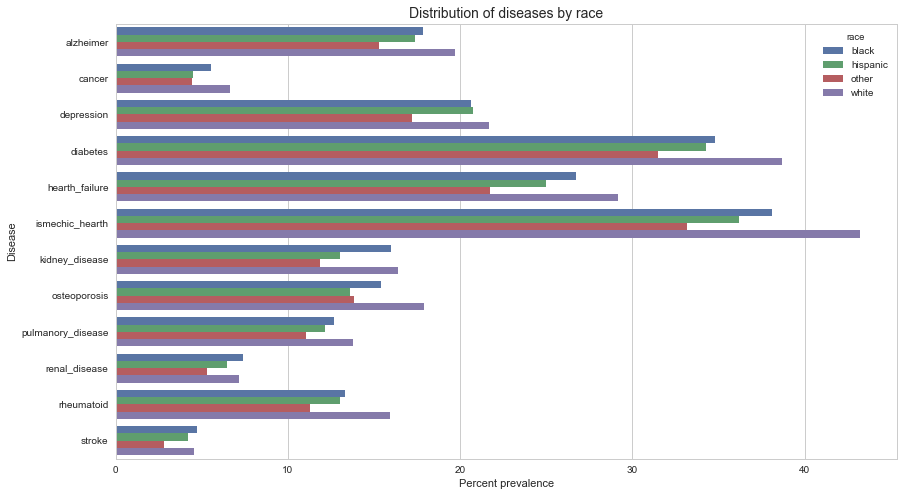

In [29]:
# Plot
fig, ax = plt.subplots(figsize=(14,8))
ax = sns.barplot(y = 'disease', x = 'prevalence', data = df3, hue = 'race')
ax.set(ylabel = 'Disease', xlabel = 'Percent prevalence')
plt.title("Distribution of diseases by race",fontsize=14)
plt.show()

Across all the states, white patients seem to have the highest prevalence of all medical conditions.

### Distribution of medical conditions among races: Comparison of CA and IL

Let's compare distribution of diseases across racial backgrounds again, but this time focus on CA and IL only.

In [30]:
df = beneficiaries[diseases + ['race', 'state']]
df = df[df['state'] == 5]
df2 = pd.melt(df, value_vars=diseases, value_name = 'has_disease', var_name='disease', id_vars = 'race')
df3 = df2.groupby(['race','disease'])['has_disease'].sum().reset_index()

race_counts = df.groupby('race').size().reset_index()
race_counts.columns = ['race','race_counts']
df3 = pd.merge(df3,race_counts, how='left', on='race')
df3['prevalence'] = df3['has_disease'] / df3['race_counts'] *100

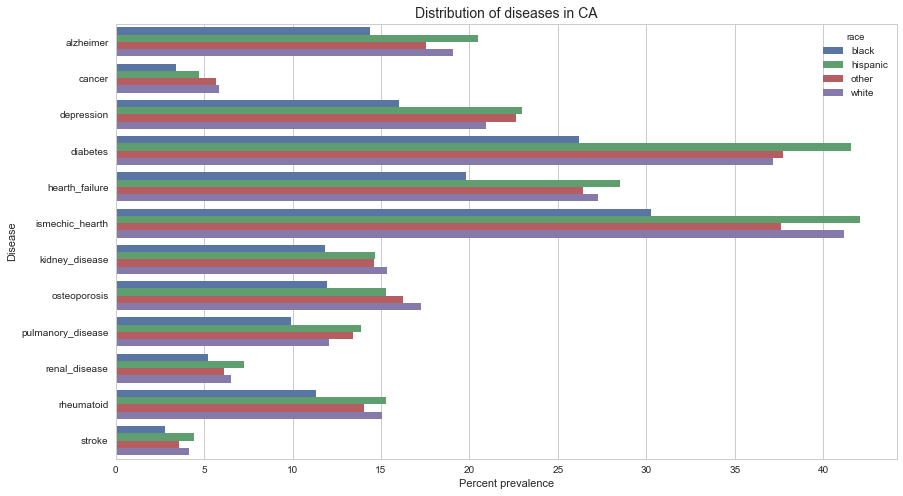

In [31]:
# Plot
fig, ax = plt.subplots(figsize=(14,8))
ax = sns.barplot(y = 'disease', x = 'prevalence', data = df3, hue = 'race')
ax.set(ylabel = 'Disease', xlabel = 'Percent prevalence')
plt.title("Distribution of diseases in CA",fontsize=14)
plt.show()

In [32]:
df = beneficiaries[diseases + ['race', 'state']]
df = df[df['state'] == 14]
df2 = pd.melt(df, value_vars=diseases, value_name = 'has_disease', var_name='disease', id_vars = 'race')
df3 = df2.groupby(['race','disease'])['has_disease'].sum().reset_index()

race_counts = df.groupby('race').size().reset_index()
race_counts.columns = ['race','race_counts']
df3 = pd.merge(df3,race_counts, how='left', on='race')
df3['prevalence'] = df3['has_disease'] / df3['race_counts'] *100

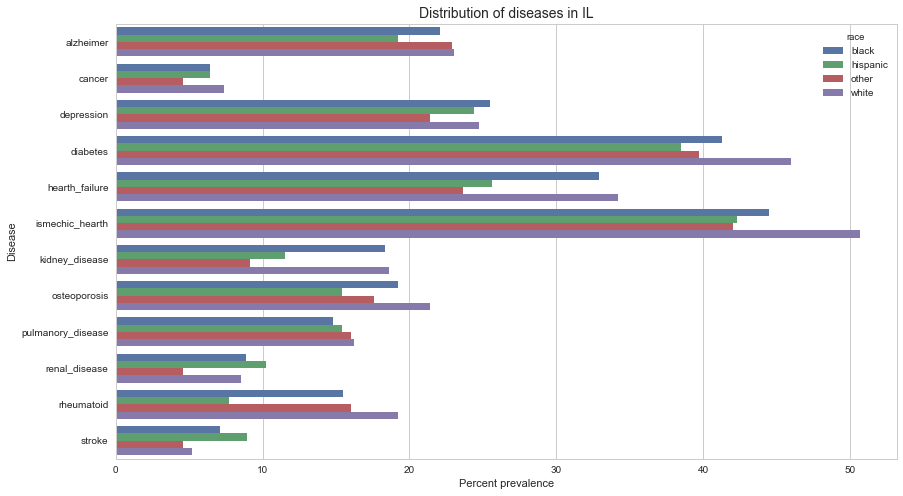

In [33]:
# Plot
fig, ax = plt.subplots(figsize=(14,8))
ax = sns.barplot(y = 'disease', x = 'prevalence', data = df3, hue = 'race')
ax.set(ylabel = 'Disease', xlabel = 'Percent prevalence')
plt.title("Distribution of diseases in IL",fontsize=14)
plt.show()

While for most conditions in CA, hispanic patients have the highest prevalence, for IL, this is true for white patients. This is probably correlated to the difference between demographics between states.

## Conclusions

From this simple exploratory analysis, we come up with the following conclusions:

1. Hearth related conditions are the most prevalent across all the states, as well as within each state
2. While stroke is one of the least prevalent medical condition, it has the highest cost of treatment
3. inpatient expenses have the largest share in the top percentile, and non-existent in the lowest percentile. Instead outpatient expenses dominate the lower percentile of payments. 
4. Medical condition prevalence is more or less uniform between gender.
5. White patients have the highest prevalence of all medical conditions across the nation, while each states can differ based on its own deomgraphic distribution. 